# Importing Libraries

In [1]:
import sys
sys.path.append('..')
from scripts.model import Model
from scripts.processor import Processor
from src.load import load_csv
from src.plot import Plot
import warnings
warnings.filterwarnings('ignore')
model = Model()
processor = Processor()
ploter = Plot()

## Loading Clean Data

In [2]:
PATH = '../data/clean_ML_rating.csv'
df = load_csv(PATH)
df.drop(columns=['Unnamed: 0'], inplace=True, errors='ignore')
df.head(5)

,UnderwrittenCoverID,PolicyID,TransactionMonth,IsVATRegistered,Citizenship,LegalType,Title,Language,Bank,AccountType,...,CoverCategory,CoverType,CoverGroup,Section,Product,StatutoryClass,StatutoryRiskType,TotalPremium,TotalClaims,Month
0,145249,12827,2015-03-01,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Windscreen,Windscreen,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,21.929825,0.0,2015-03
1,145249,12827,2015-05-01,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Windscreen,Windscreen,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,21.929825,0.0,2015-05
2,145249,12827,2015-07-01,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Windscreen,Windscreen,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,0.000000,0.0,2015-07
3,145255,12827,2015-05-01,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Own damage,Own Damage,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,512.848070,0.0,2015-05
4,145255,12827,2015-07-01,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Own damage,Own Damage,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,0.000000,0.0,2015-07


## Encode categorical variables

In [3]:
columns_label = ['Gender']
columns_onehot = ['Province']

df = processor.encoder(df, columns_label=columns_label, columns_onehot=columns_onehot)
df.filter(regex="Province").head(5)



,Province_Eastern Cape,Province_Free State,Province_Gauteng,Province_KwaZulu-Natal,Province_Limpopo,Province_Mpumalanga,Province_North West,Province_Northern Cape,Province_Western Cape
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


## Split features and target

In [4]:
df_claims = df[df['TotalClaims'] > 0]
X = df_claims.filter(regex="Province|Gender")
y = df_claims['TotalClaims']
X_train, X_test, y_train, y_test = model.split_data(X, y, test_size=0.2)

## Clean X_train and X_test to remove strings / whitespace


In [5]:
X_train = X_train.select_dtypes(exclude=['object'])
X_test = X_test.select_dtypes(exclude=['object'])

# Ensure all numeric
X_train = X_train.astype(float)
X_test = X_test.astype(float)

## Scale numeric columns

In [6]:
columns_scaler = ['TotalClaims']
y_train = y_train.to_frame()
y_test = y_test.to_frame()
y_train = processor.scaler('standardScaler', y_train, columns_scaler)

y_test = processor.scaler('standardScaler', y_test, columns_scaler)

## Train all models

In [7]:
model.train_model(X_train, y_train)


In [8]:
models_list = ['Linear Regression', 'Decision Tree', 'Random Forest', 'XGBoost']
models_obj = [model.lr_model, model.dt_model, model.rfr_model, model.xgb_model]

mae_scores, mse_scores, r2_scores = [], [], []

for m in models_obj:
    mae, mse, r2, _ = model.evaluate_model(m, X_test, y_test)
    mae_scores.append(mae)
    mse_scores.append(mse)
    r2_scores.append(r2)

# Print results
for i, name in enumerate(models_list):
    print(f"{name} → MAE: {mae_scores[i]:.4f}, MSE: {mse_scores[i]:.4f}, R2: {r2_scores[i]:.4f}")


Linear Regression → MAE: 0.6191, MSE: 0.9955, R2: 0.0045
Decision Tree → MAE: 0.6187, MSE: 0.9941, R2: 0.0059
Random Forest → MAE: 0.6186, MSE: 0.9936, R2: 0.0064
XGBoost → MAE: 0.6187, MSE: 0.9941, R2: 0.0059


In [9]:
for i, model_name in enumerate(models_list):    
    print(f"Evaluation results for {model_name}:")
    print(f" - Mean Absolute Error (MAE): {mae_scores[i]}")
    print(f" - Mean Squared Error (MSE): {mse_scores[i]}")
    print(f" - R-squared (R2) Score: {r2_scores[i]}")
    print("\n")


Evaluation results for Linear Regression:
 - Mean Absolute Error (MAE): 0.6190969011528705
 - Mean Squared Error (MSE): 0.9954636966406282
 - R-squared (R2) Score: 0.004536303359371829


Evaluation results for Decision Tree:
 - Mean Absolute Error (MAE): 0.6186915237399261
 - Mean Squared Error (MSE): 0.9941304325817382
 - R-squared (R2) Score: 0.005869567418261834


Evaluation results for Random Forest:
 - Mean Absolute Error (MAE): 0.61863902454415
 - Mean Squared Error (MSE): 0.9935682527179347
 - R-squared (R2) Score: 0.006431747282065303


Evaluation results for XGBoost:
 - Mean Absolute Error (MAE): 0.6186984181404114
 - Mean Squared Error (MSE): 0.9941314458847046
 - R-squared (R2) Score: 0.00586855411529541




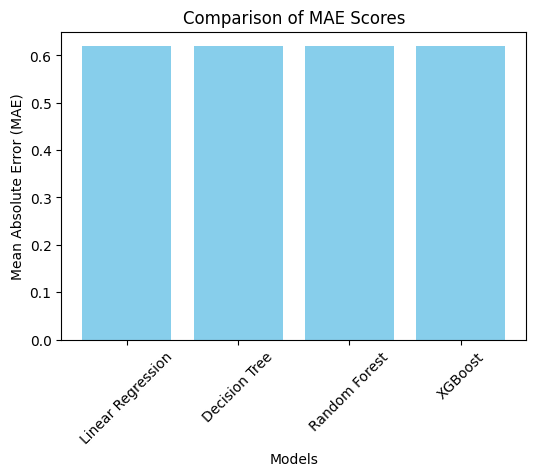

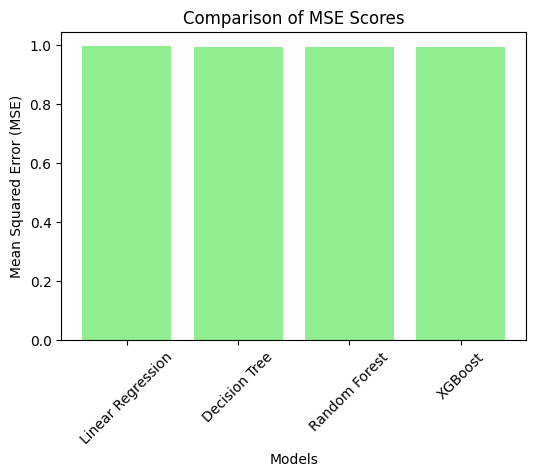

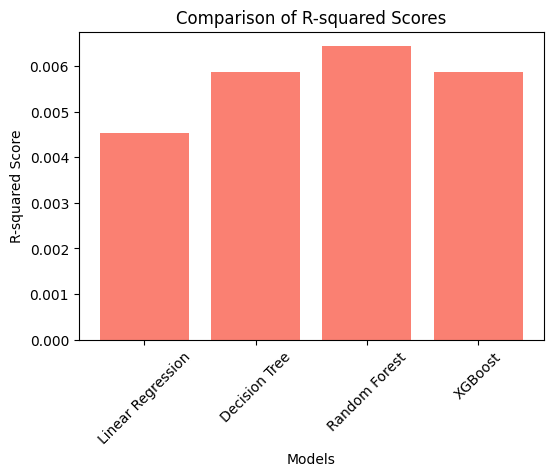

In [10]:
ploter.plot_metrics(models=models_list, mae_scores=mae_scores, mse_scores=mse_scores, r2_scores=r2_scores)

### DECISION TREE VISUALIZATION

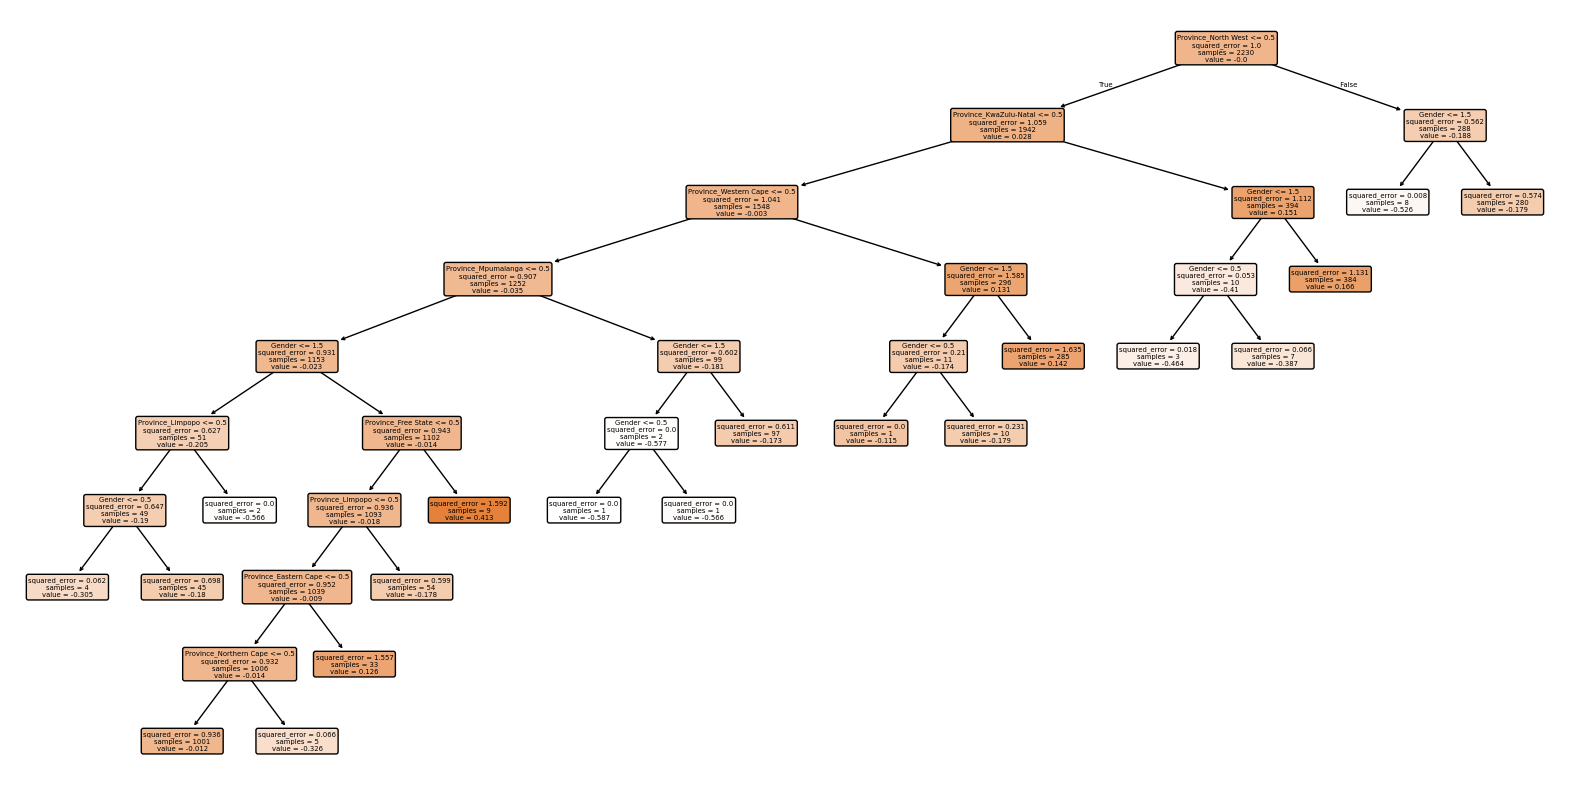

In [12]:
ploter.tree_plot(model.dt_model, X_train.columns)

### Compares which features matter most across different models.

<Figure size 1000x600 with 0 Axes>

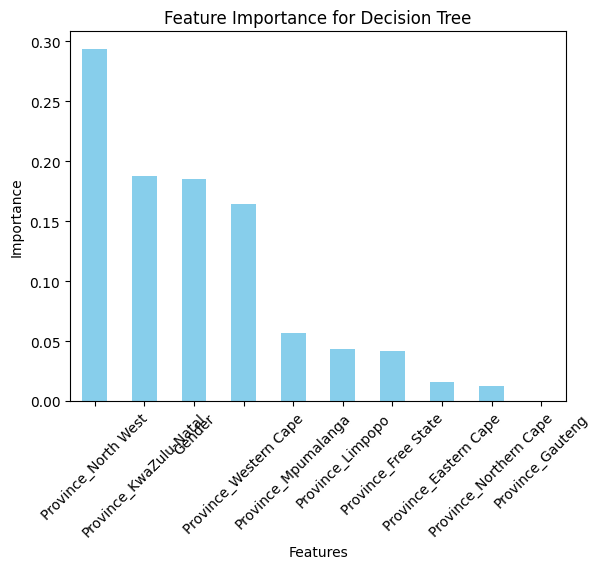

<Figure size 1000x600 with 0 Axes>

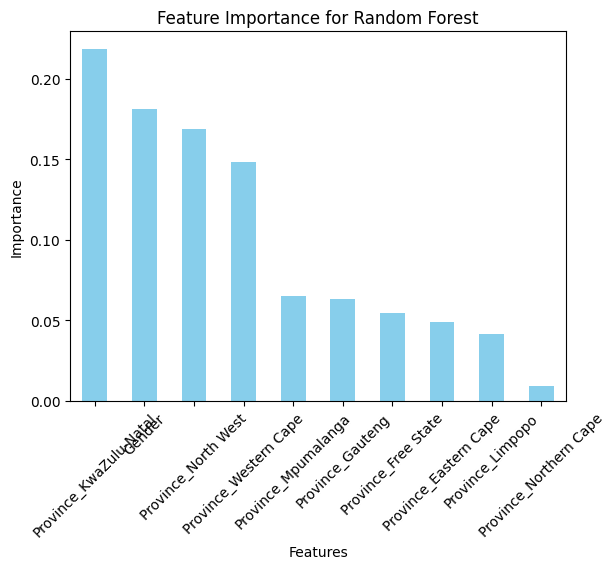

<Figure size 1000x600 with 0 Axes>

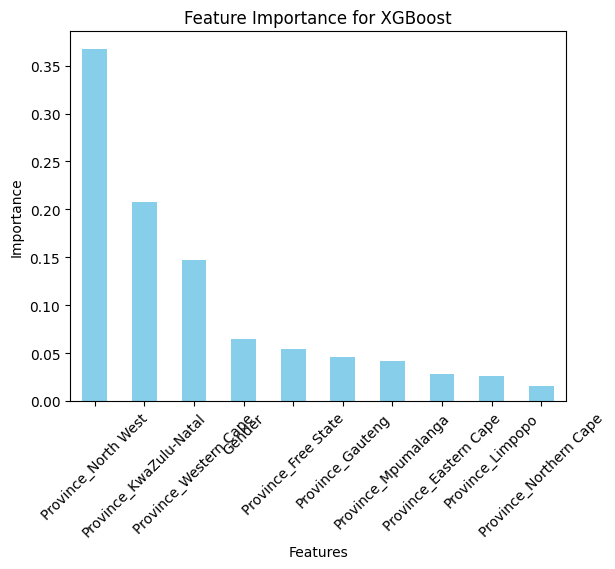

In [11]:
ploter.plot_feature_importance(model.dt_model, X_train.columns[:10], "Decision Tree")
ploter.plot_feature_importance(model.rfr_model, X_train.columns[:10], "Random Forest")
ploter.plot_feature_importance(model.xgb_model, X_train.columns[:10], "XGBoost")